### This file is for generating transformed image data
and storing them in numpy files

*******************************************************************************************
This file and the project artefact items are the integral parts of the submission for
<br>
Independent Research Project, <br>
(COM00151M) 2024 <br>
Computer Science with Artificial Intelligence,  <br>
Computer Science Dept.  <br>
University of York <br>
<br>
Project title: Hybrid CNN-LSTM with Image Data Augmentation for Bean Leaf Disease Classification<br>
Dated 21 Oct 2024 <br>
by Hye Jin Rhee
********************************************************************************************

# Imports

In [2]:
import numpy as np
import pandas as pd

import random
from skimage import exposure, io, transform
from scipy import misc, ndimage
from matplotlib import pyplot as plt
import cv2 as cv

%matplotlib inline

#### Set random seeds

In [3]:
# Set random seeds - for repducibility
seed = 777
random.seed(seed)
np.random.seed(seed)

# Constants

In [4]:
WIDTH = 300 # image width
HEIGHT = 300  #image height
CHANNELS = 3
SHAPE = [WIDTH, HEIGHT, CHANNELS]
IMAGE_SIZE = [WIDTH, HEIGHT]
TOTAL_INPUTS = WIDTH * HEIGHT * CHANNELS
LABELS = ['Angular Leaf Spot', 'Bean Rust','Healthy']

# ORIGINAL DATA TO BE READ 
X_TRAIN = 'x_train_original.npy'  #905
Y_TRAIN = 'y_train_original.npy'  #905

## Transformed data files 
X_TRAIN_ROTATE = 'x_train_rotate.npy'
Y_TRAIN_ROTATE = 'y_train_rotate.npy'
X_TRAIN_FLIP = 'x_train_flip.npy'
Y_TRAIN_FLIP = 'y_train_flip.npy'
X_TRAIN_CROP = 'x_train_crop.npy'
Y_TRAIN_CROP = 'y_train_crop.npy'
X_TRAIN_COMBINE = 'x_train_combine.npy'
Y_TRAIN_COMBINE = 'y_train_combine.npy'
X_TRAIN_BRIGHT = 'x_train_bright.npy'
Y_TRAIN_BRIGHT = 'y_train_bright.npy'

# total number of training samples original and augmented
NR_SAMPLES = 905 
AUG_SAMPLES = 2715


# Core Functions
Functions used to read data, check stats, transform images and save to numpy files

In [1]:

def describe_data(data):
    """
    This function describe the image data information
    descriptive stats and data shape. It also generate 
    the histogram of the image data
    """
    #descriptive stats
    print(f'mean average: {np.mean(data)}')
    print(f'min: {np.min(data)}, max = {np.max(data)}')
    print(f'median: {np.median(data)}')
    print(f'standard diviation: {np.std(data)}')
    print(f'Data shape: {data.shape}')
    # generate histogram for 2d-array
    print('Image data distribution')
    if type(data)==list:
        plt.hist(data)
    else:
        data = list(data)
        plt.hist(data)


def check_class_distribution(target, name):
    """
    This function checks target distributions and 
    generate a histogram.
    """
    print(f'{name}')
    counts = [np.size(np.where(target==0)), 
              np.size(np.where(target==1)), 
              np.size(np.where(target==2)) ]
    print(f'{LABELS[0]}: {counts[0]}, {LABELS[1]}: {counts[1]}, {LABELS[2]}: {counts[2]}' )
    # Bar plot
    fig, ax = plt.subplots()
    plt.title('Target value distribution', fontsize=16)
    ax.bar(LABELS, counts, width=0.5, color='grey' )
    plt.xlabel('Classes', fontsize=15)
    plt.ylabel('Samples', fontsize=15)
    plt.show();


# load the original data to be transformed and displays brief info
def load_original_data():
    features = np.load(X_TRAIN)
    labels = np.load(Y_TRAIN) 
    
    print('Image data description')
    describe_data(features)
    
    features = np.reshape(features, (-1, HEIGHT, WIDTH, CHANNELS))
    print(f'Data shape = X: {features.shape}, Y: {labels.shape}')
    return (features, labels)


# show sample images 
def visualise_image(nums):
  fig = plt.figure(figsize=(8, 8))
  for i in range(len(nums)):
    ax = plt.subplot(3, 3, i+1)
    # get label name
    plt.title(LABELS[Y_train[nums[i]]])
    # get image
    plt.imshow((x_train[nums[i]]))
    plt.axis('off')


# Geometric Transformations
def flip_horizontal(image):  # flip around the x-axis
    return (cv.flip(image, flipCode=0), 'Horizontal Flip')

def flip_vertical(image):  # flip around the y-axis
    return (cv.flip(image, flipCode=1), 'Vertical Flip')
  


def rotate_15_clockwise(image):
    result = ndimage.rotate(input=image, angle=-15, axes=(1,0), reshape=False, mode='reflect', cval=0)
    result = np.clip(result, 0, 255) # set the range
    return (result, 'Rotation')

def rotate_15_counterclockwise(image):
    result = ndimage.rotate(input=image, angle=15, axes=(1,0), reshape=False, mode='reflect', cval=0)
    result = np.clip(result, 0, 255) # set the range
    return (result, 'Rotation')


def crop_image(image, factor):
    height, width = image.shape[:2]
    crop_factor = np.clip(factor, 0, 1)
    new_height = int(height * crop_factor)
    new_width = int(width * crop_factor)
    y_start = np.random.randint(0, height - new_height + 1)
    x_start = np.random.randint(0, width - new_width + 1)
    cropped_image = image[y_start: y_start+new_height, x_start:x_start+new_width]
    cropped_image = cropped_image.astype(np.uint8) # it does not like other int
    resized_image = cv.resize(cropped_image, (WIDTH, HEIGHT), interpolation=cv.INTER_CUBIC)
    return (resized_image, 'Cropping')
    

def increase_brightness(image, value):
    image = np.float32(image)
    
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv.merge((h, s, v))
    new_image = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    result = new_image.astype(np.uint8)
    result = np.reshape(result, SHAPE)
    return (result, 'Increased Brightness')


#show a single image
def show_image(data):
    try:
        plt.imshow(data)
        plt.axis('off')
    except IndexError:
        print('No image to show')

def visualise_augmented_image(image):
    li = [(image,'Original'),
          rotate_15_clockwise(image), 
          flip_vertical(image),
          flip_horizontal(image),
          increase_brightness(image, value=30),
          crop_image(image, 0.8)
            ]
    fig = plt.figure(figsize=(12, 12))
    for i in range(len(li)):
        ax = plt.subplot(3, 3, i+1)
        plt.title(li[i][1], fontsize=15)
        show_image(li[i][0])


# Load stored Numpy files
def verify_stored_data(r, x, y):
    """
    This function load the stored image file,
    reshape into 3-d array and
    returns the features and target seperately
    """
    # Load NPY files
    image = np.load(x)
    label = np.load(y)
    show_image(np.reshape(image[r], SHAPE))
    print(LABELS[label[r]])
    print(f'Image data info : {image.shape}')
    return (image, label)


# Load data
Load the original data in numpy file and check dimension and basic descrptive stats
** This cell must run before any transformations to load the original set

Image data description
mean average: 112.0990950726417
min: 0, max = 255
median: 112.0
standard diviation: 58.28370397582354
Data shape: (905, 270000)
Image data distribution
Data shape = X: (905, 300, 300, 3), Y: (905,)
CPU times: total: 17.8 s
Wall time: 18.9 s


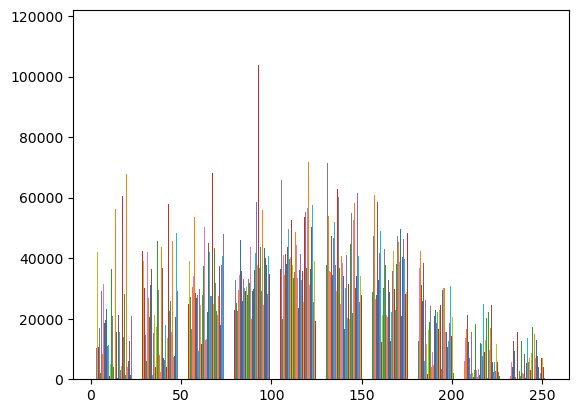

In [5]:
%%time
X, Y = load_original_data()

Angular Leaf Spot


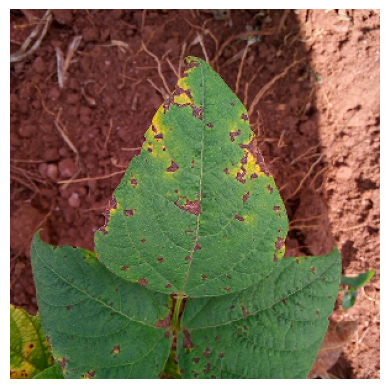

In [10]:
# Check one image
num = 138

show_image(X[num])
print(LABELS[Y[num]])

### Check distribution of the labels

y_train_original.npy
Angular Leaf Spot: 304, Bean Rust: 307, Healthy: 294


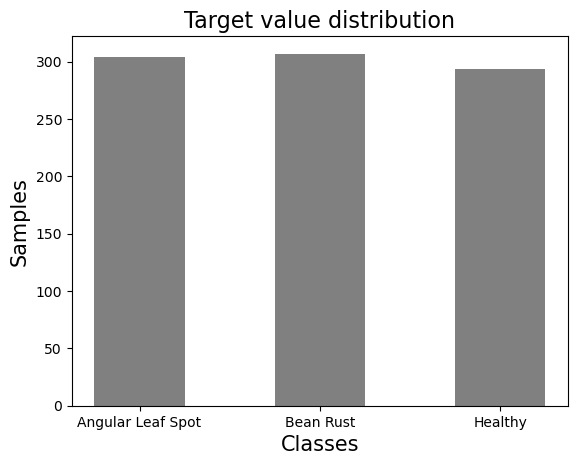

In [7]:
check_class_distribution(target=Y, name=Y_TRAIN)

### Preview transformations

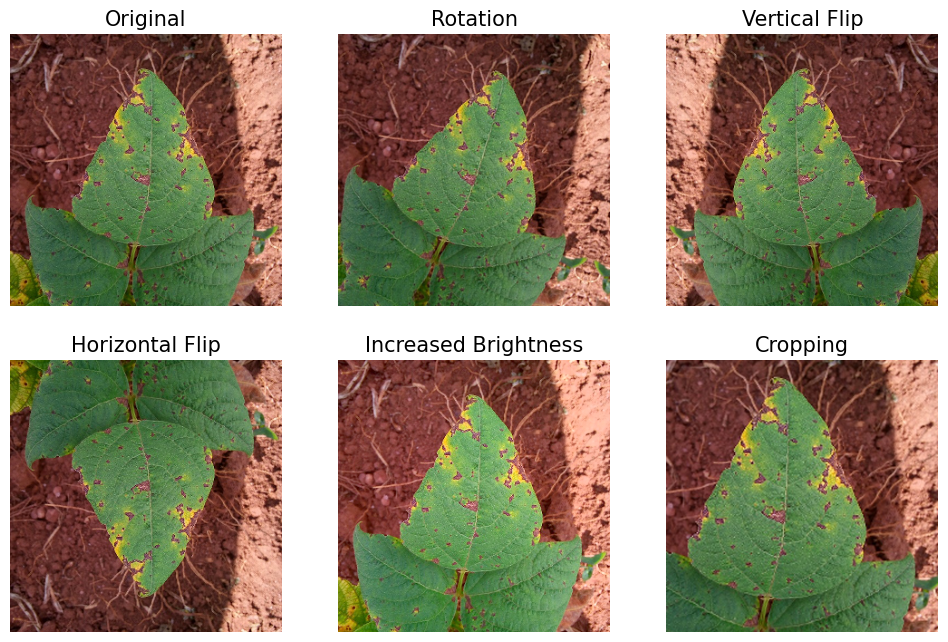

In [13]:
visualise_augmented_image(X[num])

# Geometric transformations
Run each tranformation in different times

In [6]:

def generate_transform_rotate(x, y):
    """
    This funtion generated transformed data using the
    rotate transformation with 2 different settings for 300% oversampling
    """
    a = [rotate_15_clockwise(x[i])[0] for i in range(NR_SAMPLES)]
    b = [rotate_15_counterclockwise(x[i])[0] for i in range(NR_SAMPLES)]

    # Added onto the original sample
    features = np.concatenate((x, a, b), axis=0)
    labels = np.concatenate((y, y, y), axis=0)
    print(f'X size: {len(features)}, Y size: {len(labels)}' )  
    return (features, labels)


def generate_transform_flip(x, y):
    """
    This funtion generated transformed data using the
    flip transformation with 2 different settings for 300% oversampling
    """
    a = [flip_horizontal(x[i])[0] for i in range(NR_SAMPLES)]
    b = [flip_vertical(x[i])[0] for i in range(NR_SAMPLES)]

    # Added onto the original sample
    features = np.concatenate((x, a, b), axis=0)
    labels = np.concatenate((y, y, y), axis=0)
    print(f'X size: {len(features)}, Y size: {len(labels)}' )  
    return (features, labels)



def generate_transform_exposure(x, y):
    """
    This funtion generated transformed data using the
    gaussian filter transformation with 2 different settings for 300% oversampling
    """
    a = [increase_brightness(x[i], 20)[0] for i in range(NR_SAMPLES)]
    b = [increase_brightness(x[i], 30)[0] for i in range(NR_SAMPLES)]

    # Added onto the original sample
    features = np.concatenate((x, a, b), axis=0)
    labels = np.concatenate((y, y, y), axis=0)
    print(f'X size: {len(features)}, Y size: {len(labels)}' )  
    return (features, labels)


def generate_transform_crop(x, y):
    """
    This funtion generated transformed data using the
    rotate transformation with 2 different settings for 300% oversampling
    """
    a = [crop_image(x[i], 0.9)[0] for i in range(NR_SAMPLES)]
    b = [crop_image(x[i], 0.8)[0] for i in range(NR_SAMPLES)]
  
    # Added onto the original sample
    features = np.concatenate((x, a, b), axis=0)
    labels = np.concatenate((y, y, y), axis=0)
    print(f'X size: {len(features)}, Y size: {len(labels)}' )  
    return (features, labels)



def generate_transform_combination(x, y):
    """
    This funtion generated transformed data using the
    4 transformans with 2 settings for 300% oversampling
    """
    # transformations
    a = [rotate_15_clockwise(x[i])[0] for i in range(226)]
    b = [rotate_15_counterclockwise(x[i+226])[0] for i in range(226)]
    c = [flip_horizontal(x[i+452])[0] for i in range(226)]
    d = [flip_vertical(x[i+678])[0] for i in range(227)]
    e = [crop_image(x[i], 0.9)[0] for i in range(226)]
    f = [crop_image(x[i+226], 0.8)[0] for i in range(226)]
    g = [increase_brightness(x[i+452], 20)[0] for i in range(226)]
    h = [increase_brightness(x[i+678], 30)[0] for i in range(227)]
   
    features = np.concatenate((x, a, b, c, d, e, f, g, h), axis=0)
    labels = np.concatenate((y, y, y), axis=0)
    print(f'X size: {len(features)}, Y size: {len(labels)}' )  
    return (features, labels)


def shuffle_transformed_data(features, labels):
    """
    This function shuffles the image data array
    randomly and split into feature and the target
    """
    # Flatten the image array
    li = []
    for i in range(len(features)):
        li.append(features[i].flatten())
    labels = np.reshape(labels, (AUG_SAMPLES, -1)) 

    # RANDOM SHUFFLE concatenate X+Y
    xy = np.concatenate((li, labels), axis=1)
    # shuffle the merged augmented data X+Y
    xy = np.random.default_rng(seed=seed).permutation(xy)

    # Split the merged data into X and Y
    X = [xy[i][:TOTAL_INPUTS] for i in range(AUG_SAMPLES)]
    Y = [xy[i][TOTAL_INPUTS] for i in range(AUG_SAMPLES)]
    # Check Final output
    print(f'Output data: X size: {len(X)}, Y size: {len(Y)}')
    # return the flattened, shuffled transformed data 
    return (X, Y)


def store_transformed_data(x, x_filename, y, y_filename):
    np.save(x_filename, x)
    np.save(y_filename, y)
    print('Data successfully stored')


## Transformations
#### *Note: This process reuses the variables!
X, Y must be the original data on the cell above

### Rotate

Image data description
mean average: 112.0990950726417
min: 0, max = 255
median: 112.0
standard diviation: 58.28370397582354
Data shape: (905, 270000)
Image data distribution
Data shape = X: (905, 300, 300, 3), Y: (905,)
X size: 2715, Y size: 2715
Output data: X size: 2715, Y size: 2715
Data successfully stored
CPU times: total: 1min 37s
Wall time: 1min 44s


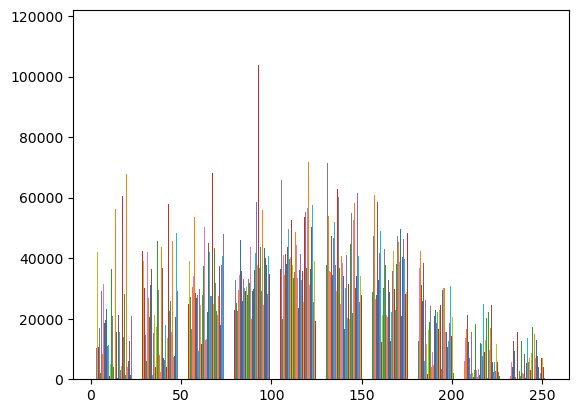

In [94]:
%%time
X, Y = load_original_data()
A, B = generate_transform_rotate(X, Y)
X, Y = shuffle_transformed_data(A, B)
store_transformed_data(X, X_TRAIN_ROTATE, Y, Y_TRAIN_ROTATE)


### Flip

Image data description
mean average: 112.0990950726417
min: 0, max = 255
median: 112.0
standard diviation: 58.28370397582354
Data shape: (905, 270000)
Image data distribution
Data shape = X: (905, 300, 300, 3), Y: (905,)
X size: 2715, Y size: 2715
Output data: X size: 2715, Y size: 2715
Data successfully stored
CPU times: total: 24.6 s
Wall time: 28.7 s


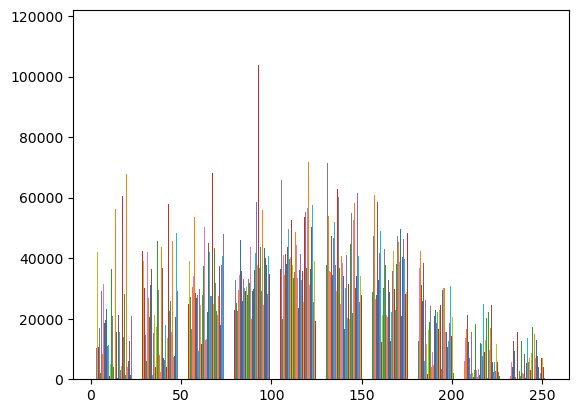

In [106]:
%%time
X, Y = load_original_data()
A, B = generate_transform_flip(X, Y)
X, Y = shuffle_transformed_data(A, B)
store_transformed_data(X, X_TRAIN_FLIP, Y, Y_TRAIN_FLIP)

### Cropping

Image data description
mean average: 112.0990950726417
min: 0, max = 255
median: 112.0
standard diviation: 58.28370397582354
Data shape: (905, 270000)
Image data distribution
Data shape = X: (905, 300, 300, 3), Y: (905,)
X size: 2715, Y size: 2715
Output data: X size: 2715, Y size: 2715
Data successfully stored
CPU times: total: 24.5 s
Wall time: 31.9 s


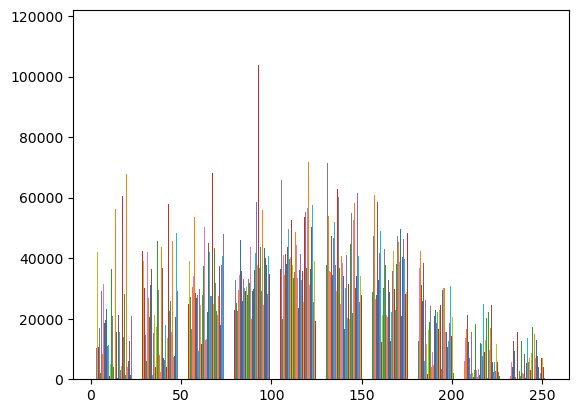

In [137]:
%%time
X, Y = load_original_data()
A, B = generate_transform_crop(X, Y)
X, Y = shuffle_transformed_data(A, B)
store_transformed_data(X, X_TRAIN_CROP, Y, Y_TRAIN_CROP)

### Increase brightness

Image data description
mean average: 112.0990950726417
min: 0, max = 255
median: 112.0
standard diviation: 58.28370397582354
Data shape: (905, 270000)
Image data distribution
Data shape = X: (905, 300, 300, 3), Y: (905,)
X size: 2715, Y size: 2715
Output data: X size: 2715, Y size: 2715
Data successfully stored
CPU times: total: 29.3 s
Wall time: 34 s


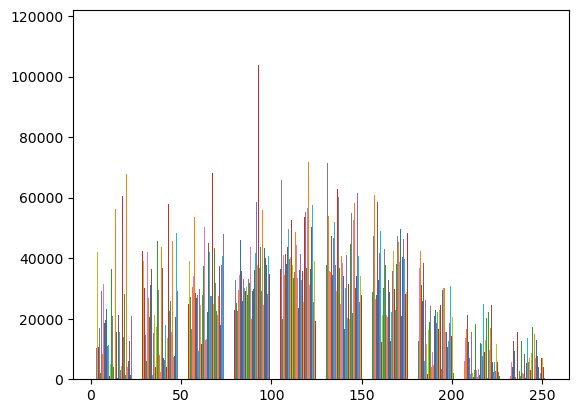

In [117]:
%%time
X, Y = load_original_data()
A, B = generate_transform_exposure(X, Y)
X, Y = shuffle_transformed_data(A, B)
store_transformed_data(X, X_TRAIN_BRIGHT, Y, Y_TRAIN_BRIGHT)

### Combination

Image data description
mean average: 112.0990950726417
min: 0, max = 255
median: 112.0
standard diviation: 58.28370397582354
Data shape: (905, 270000)
Image data distribution
Data shape = X: (905, 300, 300, 3), Y: (905,)
X size: 2715, Y size: 2715
Output data: X size: 2715, Y size: 2715
Data successfully stored
CPU times: total: 41.4 s
Wall time: 47.5 s


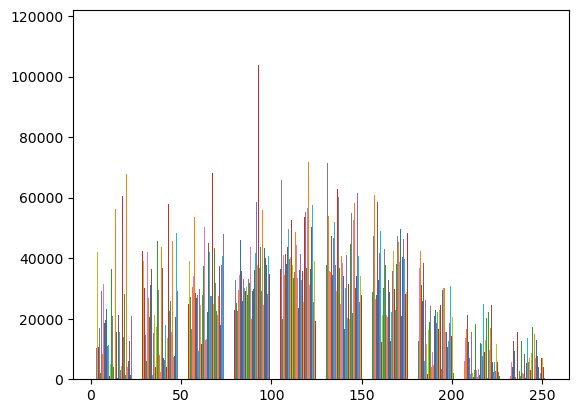

In [7]:
%%time
X, Y = load_original_data()
A, B = generate_transform_combination(X, Y)
X, Y = shuffle_transformed_data(A, B)
store_transformed_data(X, X_TRAIN_COMBINE, Y, Y_TRAIN_COMBINE)

Licence for programs:
All programs and data written for this project use the Apache license, 
the details can be found here:
http://www.apache.org/licenses/


Raw image data: 
The ibean data  with the following details and uses the MIT Licence.
@ONLINE {beansdata,
    author="Makerere AI Lab",
    title="Bean disease dataset",
    month="January",
    year="2020",
    url="https://github.com/AI-Lab-Makerere/ibean/"
}
